# Stock Martket Analysis Notebook

Includes:
* EDA
* Feature Engineering
* Modeling (using Pytorch)
* MLFlow tracking

steps:
1. Pull OHLCV data with yfinance
2. Explore/Plot data (EDA)
3. Engineer rolling/lag features
4. Train Pytorch MLP classifier
5. Track experiments in MLFlow (params, metrics, and artifacts)
6. Package artifacts for serving

## 0. Imports/Environment

In [126]:
import warnings
warnings.filterwarnings("ignore")

import os, io, tarfile, json, time, math, pathlib
from datetime import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import joblib

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import mlflow
from mlflow import log_metric, log_param, log_artifact

from dotenv import load_dotenv

load_dotenv()

True

In [127]:
import dagshub
dagshub.init(repo_owner='RickyMartin-dev', repo_name='stock-analysis-v0', mlflow=True)

Initialized MLflow to track repo "RickyMartin-dev/stock-analysis-v0"

Repository RickyMartin-dev/stock-analysis-v0 initialized!

## 0. Configurations

Target: AAPL

In [128]:
SYMBOL = "AAPL"         # Change to any ticker symbol available in yfinance
PERIOD = "5y"           # '1y', '5y', etc.
LOOKBACK = 14           # past days used to build lag features
VAL_FRACTION = 0.2
EPOCHS = 50
BATCH_SIZE = 128
LR = 3e-3
HIDDEN = 64
DROPOUT = 0.1

# MLflow config (local by default). If you have a server, set MLFLOW_TRACKING_URI before running.
MLFLOW_EXPERIMENT = os.getenv("MLFLOW_EXPERIMENT", "stock-analysis-notebook")
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI", "file:./mlruns"))
# mlflow.create_experiment(MLFLOW_EXPERIMENT)
mlflow.set_experiment(MLFLOW_EXPERIMENT)
mlflow.autolog()

ARTIFACT_DIR = pathlib.Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)

2025/08/08 20:57:47 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/08/08 20:57:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


## 1. Download the Data from yfinance

In [129]:
# df_list = []

# for symbol in SYMBOLS:
data = yf.download(SYMBOL, period=PERIOD, auto_adjust=False, progress=False)
data = data[['Open','High','Low','Close','Volume']].dropna()
# Collapse the MultiIndex columns
data = data.stack(level=1, future_stack=True).reset_index()

# Rename 'level_1' to 'Ticker'
data = data.rename(columns={'level_1': 'Ticker'})

# Set Date back as index
data = data.set_index('Date')
# df_list.append(data)

# Combine all dataframes into a single dataframe
# df = pd.concat(data)
df = data.copy()
df.head()

Price,Ticker,Open,High,Low,Close,Volume
Date,,,,,,
2020-08-10,AAPL,112.599998,113.775002,110.000000,112.727501,212403600
2020-08-11,AAPL,111.970001,112.482498,109.107498,109.375000,187902400
2020-08-12,AAPL,110.497498,113.275002,110.297501,113.010002,165598000
2020-08-13,AAPL,114.430000,116.042503,113.927498,115.010002,210082000
2020-08-14,AAPL,114.830002,115.000000,113.044998,114.907501,165565200


In [130]:
df.head()

Price,Ticker,Open,High,Low,Close,Volume
Date,,,,,,
2020-08-10,AAPL,112.599998,113.775002,110.000000,112.727501,212403600
2020-08-11,AAPL,111.970001,112.482498,109.107498,109.375000,187902400
2020-08-12,AAPL,110.497498,113.275002,110.297501,113.010002,165598000
2020-08-13,AAPL,114.430000,116.042503,113.927498,115.010002,210082000
2020-08-14,AAPL,114.830002,115.000000,113.044998,114.907501,165565200


In [131]:
df = df[['Open','High','Low','Close','Volume']].dropna()
df.head()

Price,Open,High,Low,Close,Volume
Date,,,,,
2020-08-10,112.599998,113.775002,110.000000,112.727501,212403600
2020-08-11,111.970001,112.482498,109.107498,109.375000,187902400
2020-08-12,110.497498,113.275002,110.297501,113.010002,165598000
2020-08-13,114.430000,116.042503,113.927498,115.010002,210082000
2020-08-14,114.830002,115.000000,113.044998,114.907501,165565200


In [132]:
df.shape

(1256, 5)

2. Quick EDA

Price,Open,High,Low,Close,Volume
count,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03
mean,170.319393,172.223575,168.552008,170.471270,7.727982e+07
std,35.296694,35.542347,35.139967,35.390358,3.828688e+07
min,104.540001,110.190002,103.099998,106.839996,2.323470e+07
25%,143.214996,144.877499,141.467499,143.197506,5.123852e+07
50%,168.784996,170.350006,167.004997,168.514999,6.846695e+07
75%,193.654995,194.992504,192.252499,193.605003,9.142485e+07
max,258.190002,260.100006,257.630005,259.019989,3.459376e+08


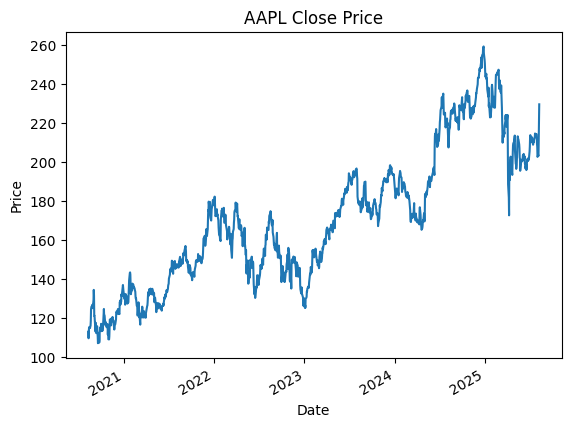

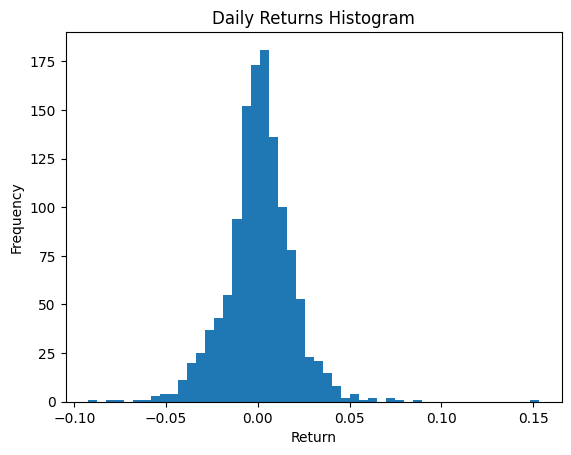

In [133]:
# for symbol in SYMBOLS: # needs to properly be able to handle multilpe
display(df.describe())

# Plot close price over time
plt.figure()
df['Close'].plot(title=f"{SYMBOL} Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# Daily returns histogram
ret = df['Close'].pct_change().dropna()
plt.figure()
plt.hist(ret.values, bins=50)
plt.title("Daily Returns Histogram")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

## 3. Build Features

In [134]:
def build_features(data: pd.DataFrame, lookback: int = 14):
    
    df = data.copy().sort_index()

    # extract features
    df["ret_1"] = df["Close"].pct_change()
    df["ma_5"] = df["Close"].rolling(5).mean()
    df["ma_10"] = df["Close"].rolling(10).mean()
    df["std_5"] = df["Close"].rolling(5).std()
    df["vol_10"] = df["ret_1"].rolling(10).std()
    df["hl_range"] = (df["High"] - df["Low"]) / df["Close"].shift(1)
    df["v_ma_5"] = df["Volume"].rolling(5).mean()
    df["v_std_5"] = df["Volume"].rolling(5).std()

    # day of the week encoding with flat column names
    df["dow"] = df.index.dayofweek
    dow = pd.get_dummies(df["dow"], prefix="dow")
    dow.columns = [f"dow_{int(col.split('_')[1])}" for col in dow.columns]
    
    # concat
    df = pd.concat([df, dow], axis=1)
    df["label"] = (df["Close"] > df["Open"]).astype(int)

    base_feats = [
        "ret_1","ma_5","ma_10","std_5","vol_10",
        "hl_range","v_ma_5","v_std_5",
    ] + [c for c in df.columns if c.startswith("dow_")]

    feat_cols = []
    for c in base_feats:
        for lag in range(1, lookback+1):
            name = f"{c}_lag{lag}"
            df[name] = df[c].shift(lag)
            feat_cols.append(name)

    df = df.dropna().copy()
    X = df[feat_cols].astype(float)
    y = df["label"].astype(int)
    return X, y

In [135]:
X, y = build_features(df, LOOKBACK)
X.shape, y.shape, y.mean()

((1232, 182), (1232,), 0.5340909090909091)

### Create Data Set

In [136]:
n = len(X)
split = int(n * (1 - VAL_FRACTION))
X_tr, X_val = X.iloc[:split], X.iloc[split:]
y_tr, y_val = y.iloc[:split], y.iloc[split:]

# Preprocess (StandardScaler)
numeric_features = X.columns.tolist()
pre = ColumnTransformer([("num", StandardScaler(), numeric_features)], remainder="drop")
pre_pipe = Pipeline([("pre", pre)])
print(type(pre_pipe))

X_trs = pre_pipe.fit_transform(X_tr)
X_vals = pre_pipe.transform(X_val)

X_trs.shape, X_vals.shape

<class 'sklearn.pipeline.Pipeline'>


2025/08/08 20:57:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f8ba4193614547e6b4e34df4e53d1acb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/08/08 20:57:55 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/08/08 20:57:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


((985, 182), (247, 182))

In [137]:
# print(X_tr)

## 4. Train Pytorch Model

In [138]:
class MLP(nn.Module):
    def __init__(self, in_features: int, hidden: int = 64, p: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(hidden, 1),  # logits
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

in_features = X_trs.shape[1]
model = MLP(in_features, hidden=HIDDEN, p=DROPOUT)

crit = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(model.parameters(), lr=LR)

tr_ds = TensorDataset(torch.from_numpy(X_trs).float(), torch.from_numpy(y_tr.values).float())
va_ds = TensorDataset(torch.from_numpy(X_vals).float(), torch.from_numpy(y_val.values).float())
tr_dl = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True)
va_dl = DataLoader(va_ds, batch_size=BATCH_SIZE)

## 5. Train and Track

In [141]:
def evaluate(model, dl):
    model.eval()
    probs, targs = [], []
    with torch.no_grad():
        for xb, yb in dl:
            logits = model(xb)
            p = torch.sigmoid(logits).cpu().numpy()
            probs.append(p)
            targs.append(yb.cpu().numpy())
    probs = np.concatenate(probs)
    targs = np.concatenate(targs)
    preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(targs, preds)
    try:
        auc = roc_auc_score(targs, probs)
    except Exception:
        auc = float("nan")
    return acc, auc, probs, targs, preds

In [142]:
run_name = f"{SYMBOL}-lb{LOOKBACK}-h{HIDDEN}-lr{LR}"
with mlflow.start_run(run_name=run_name):
    # Params
    log_param("symbol", SYMBOL)
    log_param("lookback", LOOKBACK)
    log_param("epochs", EPOCHS)
    log_param("batch_size", BATCH_SIZE)
    log_param("lr", LR)
    log_param("hidden", HIDDEN)
    log_param("dropout", DROPOUT)

    best_val = 1e9
    best_state = None

    for epoch in range(EPOCHS):
        if epoch % 10 == 0: print(f'update {epoch}/{EPOCHS}')
        model.train()
        total = 0.0
        count = 0
        for xb, yb in tr_dl:
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()
            total += loss.item() * xb.size(0)
            count += xb.size(0)
        train_loss = total / max(count,1)

        val_acc, val_auc, _, _, _ = evaluate(model, va_dl)

        log_metric("train_loss", train_loss, step=epoch)
        log_metric("val_acc", val_acc, step=epoch)
        if not math.isnan(val_auc):
            log_metric("val_auc", val_auc, step=epoch)

        # Track best model by AUC (fallback to loss if AUC is nan)
        score = -val_acc  # smaller is better placeholder; swap if using loss
        if best_state is None or val_acc > (-score):
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    # Save artifacts
    model.load_state_dict(best_state)
    model_path = ARTIFACT_DIR / "model.pt"
    torch.save(model.state_dict(), model_path.as_posix())

    pre_path = ARTIFACT_DIR / "preprocess.pkl"
    joblib.dump(pre_pipe, pre_path.as_posix())

    # Plot ROC-like reliability: probability histogram
    _, _, probs, targs, preds = evaluate(model, va_dl)
    plt.figure()
    plt.hist(probs, bins=50)
    plt.title("Validation Probability Histogram")
    plt.xlabel("P(close>open)")
    plt.ylabel("Count")
    plt.savefig(ARTIFACT_DIR / "val_prob_hist.png")
    plt.close()

    # Confusion matrix
    cm = confusion_matrix(targs, preds)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(cm)
    ax.set_title("Confusion Matrix (Validation)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    fig.savefig(ARTIFACT_DIR / "val_confusion_matrix.png")
    plt.close(fig)

    # Tar bundle for serving
    spec = {
        "symbol": SYMBOL,
        "in_features": int(in_features),
        "lookback": int(LOOKBACK),
        "feature_columns": list(X.columns),
        "created_at": datetime.utcnow().isoformat()
    }
    with open(ARTIFACT_DIR / "feature_spec.json", "w") as f:
        json.dump(spec, f)

    bundle_path = ARTIFACT_DIR / f"{SYMBOL}_bundle.tar.gz"
    with tarfile.open(bundle_path.as_posix(), "w:gz") as tarf:
        tarf.add(model_path.as_posix(), arcname="model.pt")
        tarf.add(pre_path.as_posix(), arcname="preprocess.pkl")
        tarf.add((ARTIFACT_DIR / "feature_spec.json").as_posix(), arcname="feature_spec.json")

    # Log artifacts to MLflow
    log_artifact(model_path.as_posix())
    log_artifact(pre_path.as_posix())
    log_artifact((ARTIFACT_DIR / "val_prob_hist.png").as_posix())
    log_artifact((ARTIFACT_DIR / "val_confusion_matrix.png").as_posix())
    log_artifact(bundle_path.as_posix())

print("Training complete. Check MLflow UI for runs.")    

update 0/50
update 10/50
update 20/50
update 30/50
update 40/50
Training complete. Check MLflow UI for runs.


In [143]:
# def evaluate(model, dl):
#     model.eval()
#     probs, targs = [], []
#     cnt = 0
#     # print(dl.shape)
#     with torch.no_grad():
#         for xb, yb in dl:
#             if cnt ==  0:
#                 print(type(xb))
#                 print(xb.shape)
#                 print(xb)
#             cnt += 1
#             logits = model(xb)
#             p = torch.sigmoid(logits).cpu().numpy()
#             probs.append(p)
#             targs.append(yb.cpu().numpy())
#     probs = np.concatenate(probs)
#     targs = np.concatenate(targs)
#     preds = (probs >= 0.5).astype(int)
#     acc = accuracy_score(targs, preds)
#     try:
#         auc = roc_auc_score(targs, probs)
#     except Exception:
#         auc = float("nan")
#     return acc, auc, probs, targs, preds

# evaluate(model, va_dl)


In [144]:
# bundle = (ARTIFACT_DIR / f"{SYMBOL}_bundle.tar.gz").as_posix()
# print("Bundle:", bundle)

# pre_pipe, state_dict, spec = load_bundle(bundle)
# lookback = spec["lookback"]
# raw = yf.download(SYMBOL, period=f"{lookback+30}d", auto_adjust=False, progress=False)
# raw = raw.stack(level=1, future_stack=True).reset_index()
# # Rename 'level_1' to 'Ticker'
# raw = raw.rename(columns={'level_1': 'Ticker'})
# # Set Date back as index
# raw = raw.set_index('Date')
# raw = raw[['Open','High','Low','Close','Volume']].dropna()
# X_all, _ = build_features(raw, lookback=lookback)

# print(type(pre_pipe))
# # print('check', X_all)
# X_today = pre_pipe.transform(X_all)
# # print('check', X_today)
# # X_today = pre_pipe.transform(X_all.iloc[[-1]].values.astype(np.float32))

# model = MLP(in_features=X_today.shape[1], hidden=HIDDEN, p=DROPOUT)
# model.load_state_dict(state_dict)
# model.eval()
# # print('model:',type(model))

## 7. Simple Inference Helper 

Cell reloads the saved bundle.tar.gz

In [145]:
def load_bundle(bundle_path: str):
    with tarfile.open(bundle_path, mode="r:gz") as tarf:
        members = {m.name: m for m in tarf.getmembers()}
        model_bytes = tarf.extractfile(members["model.pt"]).read()
        pre_bytes = tarf.extractfile(members["preprocess.pkl"]).read()
        spec = json.loads(tarf.extractfile(members["feature_spec.json"]).read().decode("utf-8"))
    pre_pipe = joblib.load(io.BytesIO(pre_bytes))
    state_dict = torch.load(io.BytesIO(model_bytes), map_location="cpu")
    return pre_pipe, state_dict, spec

def predict_today(symbol: str, bundle_path: str):
    pre_pipe, state_dict, spec = load_bundle(bundle_path)
    lookback = spec["lookback"]
    raw = yf.download(symbol, period=f"{lookback+30}d", auto_adjust=False, progress=False)
    raw = raw.stack(level=1, future_stack=True).reset_index()
    # Rename 'level_1' to 'Ticker'
    raw = raw.rename(columns={'level_1': 'Ticker'})
    # Set Date back as index
    raw = raw.set_index('Date')
    raw = raw[['Open','High','Low','Close','Volume']].dropna()
    X_all, _ = build_features(raw, lookback=lookback)
    
    # print('check', X_all)
    X_today = pre_pipe.transform(X_all.iloc[[-1]])
    print('X_today:',X_today.shape)
    model = MLP(in_features=X_today.shape[1], hidden=HIDDEN, p=DROPOUT)
    model.load_state_dict(state_dict)
    model.eval()
    # print('model:',model)
    with torch.no_grad():
        # prob = torch.sigmoid(model(torch.from_numpy(X_today))).item()
        pred_ds = torch.from_numpy(X_today).float()
        logits = model(pred_ds)
        prob = torch.sigmoid(logits).cpu().numpy()
    label = int(prob >= 0.5)
    return label, float(prob)

bundle = (ARTIFACT_DIR / f"{SYMBOL}_bundle.tar.gz").as_posix()
print("Bundle:", bundle)
try:
    yhat, p = predict_today(SYMBOL, bundle)
    print(f"Prediction for {SYMBOL}: {yhat} (prob={p:.3f})")
except Exception as e:
    print("Prediction failed (likely due to data download in this environment). Run locally.\n", e)

Bundle: artifacts/AAPL_bundle.tar.gz
X_today: (1, 182)
Prediction for AAPL: 1 (prob=0.984)


## 8. Running Multiple Experiments (Grid)

In [148]:
def run_experiment(symbol: str, lookback: int, hidden: int, lr: float, epochs: int = 10):
    df = yf.download(symbol, period=PERIOD, auto_adjust=False, progress=False)
    df = df.stack(level=1, future_stack=True).reset_index()
    # Rename 'level_1' to 'Ticker'
    df = df.rename(columns={'level_1': 'Ticker'})
    # Set Date back as index
    df = df.set_index('Date')
    df = df[['Open','High','Low','Close','Volume']].dropna()
    X, y = build_features(df, lookback)
    n = len(X)
    split = int(n * (1 - VAL_FRACTION))
    X_tr, X_val = X.iloc[:split], X.iloc[split:]
    y_tr, y_val = y.iloc[:split], y.iloc[split:]
    pre = ColumnTransformer([("num", StandardScaler(), X.columns.tolist())], remainder="drop")
    pipe = Pipeline([("pre", pre)])
    X_trs = pipe.fit_transform(X_tr)
    X_vals = pipe.transform(X_val)

    model = MLP(X_trs.shape[1], hidden=hidden, p=DROPOUT)
    crit = nn.BCEWithLogitsLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    tr_ds = TensorDataset(torch.from_numpy(X_trs).float(), torch.from_numpy(y_tr.values).float())
    va_ds = TensorDataset(torch.from_numpy(X_vals).float(), torch.from_numpy(y_val.values).float())
    tr_dl = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True)
    va_dl = DataLoader(va_ds, batch_size=BATCH_SIZE)

    run_name = f"{symbol}-lb{lookback}-h{hidden}-lr{lr}"
    with mlflow.start_run(run_name=run_name):
        log_param("symbol", symbol)
        log_param("lookback", lookback)
        log_param("hidden", hidden)
        log_param("lr", lr)
        best = None
        for epoch in range(epochs):
            model.train()
            total, count = 0.0, 0
            for xb, yb in tr_dl:
                opt.zero_grad(); logits = model(xb); loss = crit(logits, yb); loss.backward(); opt.step()
                total += loss.item() * xb.size(0); count += xb.size(0)
            train_loss = total / max(count,1)
            log_metric("train_loss", train_loss, step=epoch)
            acc, auc, *_ = evaluate(model, va_dl)
            log_metric("val_acc", acc, step=epoch)
            if not math.isnan(auc):
                log_metric("val_auc", auc, step=epoch)

        # Save small artifacts
        tmp_dir = ARTIFACT_DIR / f"grid_lb{lookback}_h{hidden}_lr{lr}"
        tmp_dir.mkdir(exist_ok=True, parents=True)
        joblib.dump(pipe, (tmp_dir / "pre.pkl").as_posix())
        torch.save(model.state_dict(), (tmp_dir / "model.pt").as_posix())
        log_artifact((tmp_dir / "pre.pkl").as_posix())
        log_artifact((tmp_dir / "model.pt").as_posix())

# Example grid (keep small to start). Uncomment to run locally.
cnt = 0
for lb in [7, 14]:
    for h in [32, 64]:
        for lr in [1e-3, 3e-3]:
            print(f'experiment {cnt}')
            run_experiment(SYMBOL, lb, h, lr, epochs=10)
            cnt += 1
# print("Grid function defined. Uncomment the loop to run experiments.")

experiment 0


2025/08/08 21:04:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c52891fc141347a9b51f17ae3fc37f3e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/08/08 21:04:50 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/08/08 21:04:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


experiment 1


2025/08/08 21:05:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f4ded21e2e2648eba750ff9f86b2db1d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/08/08 21:05:47 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/08/08 21:05:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


experiment 2


2025/08/08 21:06:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0f5a2257024340dc8e7485e7f606d9d7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/08/08 21:06:43 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/08/08 21:06:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


experiment 3


2025/08/08 21:07:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6f584e7352ee4bf0bd9aab3ac135e5b1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/08/08 21:07:39 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/08/08 21:07:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


experiment 4


2025/08/08 21:08:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '657980a7585443a08f9fde3eb54bf1ff', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/08/08 21:08:35 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/08/08 21:08:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


experiment 5


2025/08/08 21:09:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8e813348f3ea45a1bfe5c1b471b3bd20', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/08/08 21:09:31 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/08/08 21:09:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


experiment 6


2025/08/08 21:10:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '059f8c05aedf4df7aa3a1e5343929b18', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/08/08 21:10:27 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/08/08 21:10:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


experiment 7


2025/08/08 21:11:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '30272fef89584602a59333750d54ba1f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/08/08 21:11:23 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/08/08 21:11:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Grid function defined. Uncomment the loop to run experiments.
